In [1]:
from clearml import Task, Logger, TaskTypes

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchmetrics import Precision, Recall, F1Score

from torchvision.datasets import CIFAR10
from torchvision.models import mobilenet_v3_large
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
task = Task.init(
    project_name='Processing and generating images course', 
    task_name='HW1 training', 
    task_type=TaskTypes.training)

In [3]:
parameters = {
    'model_name': 'baseline.pth',
    'batch_size': 1000,
    'num_classes': 10,
    'epochs': 25,
    'seed': 47,
    'string': 'my string',
    'aug_params': {
        'color_jitter': {'brightness': 0.5, 'contrast': 0.5, 'saturation': 0.5, 'hue': (-0.1, 0.1)}, 
        'random_flip': {'p': 0.5}
    }, 
    'optimizer_params': {
        'lr': 1e-3
    }
}

In [4]:
parameters = task.connect(parameters)
torch.manual_seed(parameters['seed'])
log = Logger.current_logger()

In [5]:
train_transforms = transforms.Compose(
    [transforms.ColorJitter(**parameters['aug_params']['color_jitter']),
     transforms.RandomHorizontalFlip(**parameters['aug_params']['random_flip']), 
     transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.ToTensor()]
)

train_set = CIFAR10("./data", download=True, transform=train_transforms, train=True)
val_set = CIFAR10("./data", download=True, transform=test_transforms, train=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=parameters['batch_size'])
val_loader = torch.utils.data.DataLoader(val_set, batch_size=parameters['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def show_sample(images, labels, predicted_labels=None):
    plt.figure(figsize=(20, 10), facecolor='white')
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        image = np.transpose(images[i].numpy(), (1, 2, 0)) 
        plt.imshow(image)
        if predicted_labels is not None:
            plt.title(f'{classes[labels[i]]} / {classes[predicted_labels[i]]}')
        else:
            plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

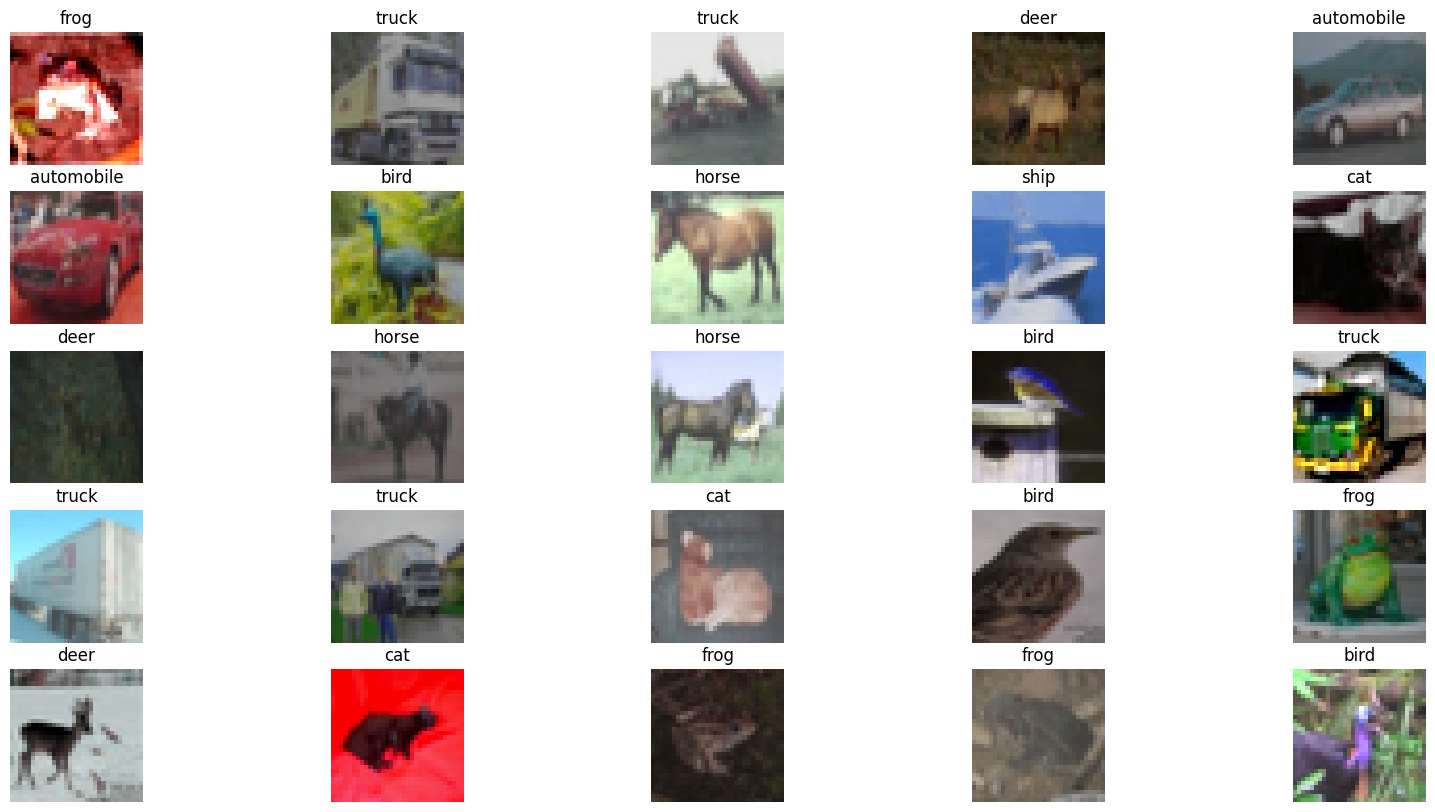

In [7]:
classes = train_set.classes
images, labels = next(iter(train_loader))
show_sample(images, labels)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = mobilenet_v3_large(weights=None)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, parameters['num_classes'])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), **parameters['optimizer_params'])

In [9]:
def log_metrics(series, iteration, precision_metric, recall_metric, f1score_metric, loss):
        log.report_histogram("PrecisionByClass", series, iteration=iteration, values=precision_metric.cpu())
        log.report_histogram("RecallByClass", series, iteration=iteration, values=recall_metric.cpu())
        log.report_histogram("F1ScoreByClass", series, iteration=iteration, values=f1score_metric.cpu())
        
        log.report_scalar("Precision", series, iteration=iteration, value=torch.mean(precision_metric).cpu())
        log.report_scalar("Recall", series, iteration=iteration, value=torch.mean(recall_metric).cpu())
        log.report_scalar("F1Score", series, iteration=iteration, value=torch.mean(f1score_metric).cpu())
        log.report_scalar("CrossEntropyLoss", series, iteration=iteration, value=loss)

In [10]:
recall = Recall(task='multiclass', average=None, num_classes=parameters['num_classes']).to(device)
precision = Precision(task='multiclass', average=None, num_classes=parameters['num_classes']).to(device)
f1score = F1Score(task='multiclass', average=None, num_classes=parameters['num_classes']).to(device)

In [11]:
for epoch in range(parameters['epochs']):
    model.train()
    train_epoch_loss = 0
    for i, data in enumerate(train_loader):
        images, targets = data
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        precision(outputs, targets)
        recall(outputs, targets)
        f1score(outputs, targets)
        
        torch.cuda.empty_cache()
    precision_metric = precision.compute()
    precision.reset()
    recall_metric = recall.compute()
    recall.reset()
    f1score_metric = f1score.compute()
    f1score.reset()
    log_metrics("Train", epoch, precision_metric, recall_metric, f1score_metric, train_epoch_loss / len(train_set))
    
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for j, data in enumerate(val_loader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)
            
            val_epoch_loss += loss.item()
            precision(outputs, targets)
            recall(outputs, targets)
            f1score(outputs, targets)
            
            torch.cuda.empty_cache()
    precision_metric = precision.compute()
    precision.reset()
    recall_metric = recall.compute()
    recall.reset()
    f1score_metric = f1score.compute()
    f1score.reset()
    log_metrics("Validation", epoch, precision_metric, recall_metric, f1score_metric, val_epoch_loss / len(val_set))

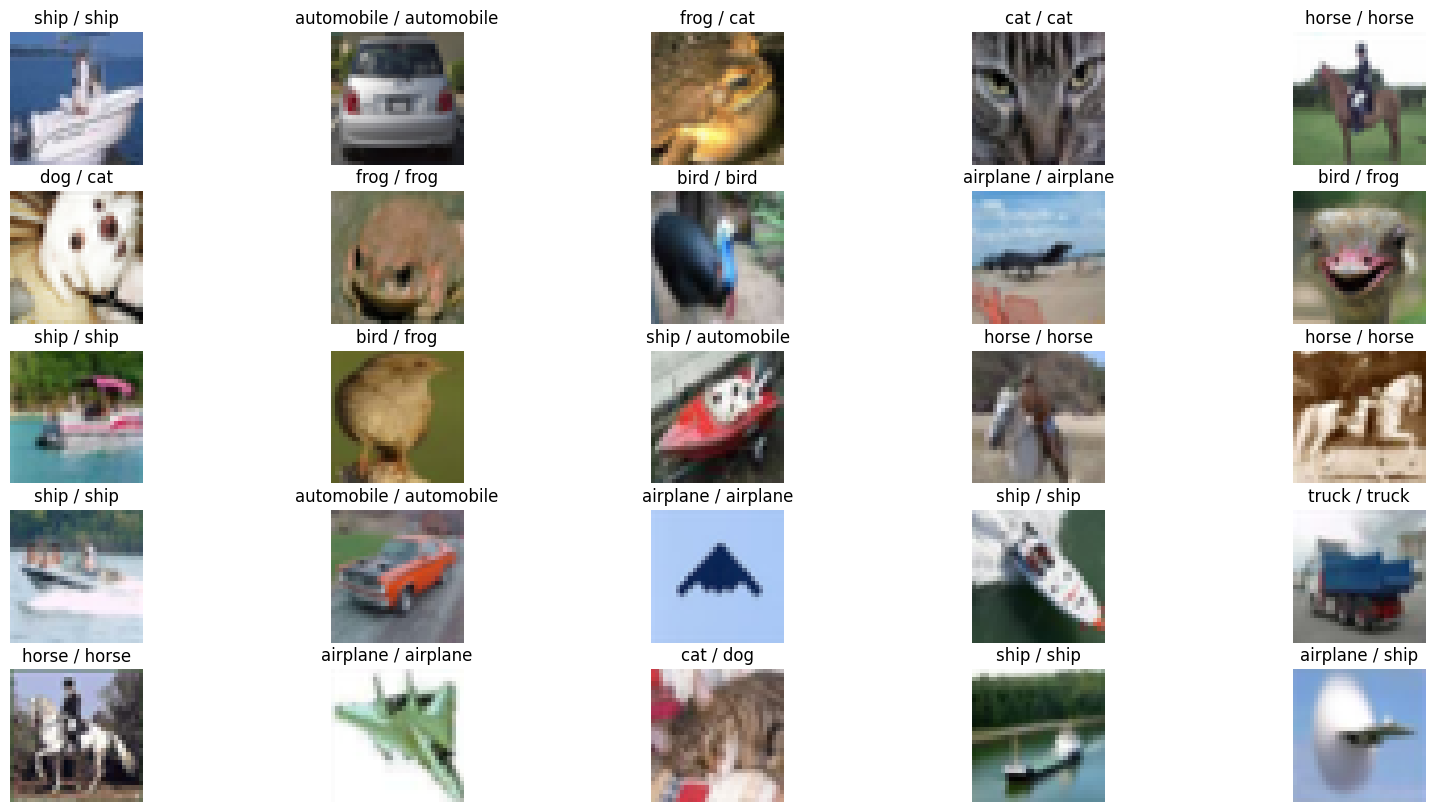

In [12]:
show_sample(images.cpu(), targets, outputs.argmax(1))

In [ ]:
torch.save(model.state_dict(), parameters['model_name'])

In [14]:
task.close()